In [249]:
date()
library(pacman)
p_load("ggplot2", "MASS", "data.table", "tidyverse", "rmarkdown")
rm(list=ls())

[1] "Tue Oct 12 12:00:56 2021"

## Simulations parameters 

In [250]:
## X distribution parameters: x ~ N(0, Sigma)
x_mu = rep(0, 6)
x_sigma = matrix(0, nrow = 6, ncol = 6)
diag(x_sigma)=1
x_sigma[1:3, 1:3] = matrix(c(1, 0.3, 0.5, 
                             0.3, 1, 0.1, 
                             0.5, 0.1, 1))


## treatment PS model parameters 
alpha=c(0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)


## potential outcomes model parameters
# beta = ... 


## simulation parameters 
sim_n= 20   # sample size
sim_N= 50   # experiment


In [251]:
## use a list to store sim parameters (and data to be added later)
sim_all= list(par=list(x_mu=x_mu, x_sigma=x_sigma, n = sim_n, N=sim_N,
                       alpha=alpha))
sim_all

1.0,0.3,0.5,0,0,0
0.3,1.0,0.1,0,0,0
0.5,0.1,1.0,0,0,0
0.0,0.0,0.0,1,0,0
0.0,0.0,0.0,0,1,0
0.0,0.0,0.0,0,0,1


In [252]:
## data simulation function 

simDataGen=function(simPar, seed=100){    
    set.seed(seed)
    
    ## x = (v1, v2, ...)
    x = mvrnorm(simPar$n, simPar$x_mu, simPar$x_sigma)
    
    ## propensity score and treatmant A
    ps = 1/(1+ exp( -(alpha[1] + x %*% simPar$alpha[-1]) ) ) 
    A = rbinom(simPar$n, size = 1, prob = ps)
    
    ## potential outcomes and observed Y
    Y1 = rnorm(simPar$n, 1)    ### model to be added
    Y0 = rnorm(simPar$n, 0)    ### model to be added
    Y = A*Y1 + (1-A)*Y0
    
    data.out = data.frame(x, ps, A, Y1, Y0, Y)
    data.out
}

In [253]:
data.try = simDataGen(simPar = sim_all$par)
data.try %>% head

,X1,X2,X3,X4,X5,X6,ps,A,Y1,Y0,Y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,0.3427055,-0.40396980,0.9565807,-0.26199577,-0.1016292,-0.4380900,0.5023400,1,0.5822056,1.03468645,0.58220557
2,0.5548995,-0.29587718,-0.6959592,-0.06884403,1.4032035,0.7640606,0.5414418,0,0.1496192,1.65350323,1.65350323
3,-0.2714682,1.24024592,-0.3875581,-0.37888356,-1.7767756,0.2619613,0.4672351,1,1.6890462,-0.01794682,1.68904619
4,-0.5072614,0.94926439,-1.9624694,2.58195893,0.6228674,0.7734046,0.5611367,0,0.5398038,-0.02420332,-0.02420332
5,-0.7638588,-0.36072654,0.8600943,0.12983414,-0.5222834,-0.8143791,0.4632832,0,2.3481844,0.25024690,0.25024690
6,-0.4862144,0.03790659,-0.1539346,-0.71302498,1.3222310,-0.4384506,0.4892145,1,1.4430714,-0.33712454,1.44307138


## Simulation: N experiments 

In [254]:
sim_all$data = lapply(1:rep(sim_all$par$N), simDataGen, simPar = sim_all$par)

In [255]:
### don't run the following code when n and N are big. 
#str(sim_all)

## Analysis 

### 1. Naive "As-Treated" estimate

In [256]:
at_effect = function(data){
    tmp = lm(Y~A, data=data) 
    cbind(coef = coef(tmp), confint(tmp) )[2,] 
}

coef,0.3305852,0.5431513,0.2493136,1.0624457,1.3530426,0.81990092,0.900677,0.8661019,0.02594331,1.2802970,⋯,0.9550746,1.1706955,1.4891464,1.1351375,0.8732731,1.18549433,0.08720658,0.2920746,1.3992894,1.0894040
2.5 %,-0.6874423,-0.2795084,-0.9058487,0.1220792,0.5974123,0.01652559,0.071519,-0.2448207,-0.81677491,0.5099639,⋯,0.1942771,0.3049077,0.6007543,0.3348397,-0.2820956,0.01992841,-0.80863145,-0.8044951,0.4065494,0.3681553
97.5 %,1.3486127,1.3658109,1.4044760,2.0028122,2.1086729,1.62327625,1.729835,1.9770246,0.86866152,2.0506301,⋯,1.7158721,2.0364832,2.3775385,1.9354353,2.0286419,2.35106025,0.98304460,1.3886443,2.3920295,1.8106527


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02594 0.65201 0.99357 0.99094 1.36536 1.79826 

[1] 0.94

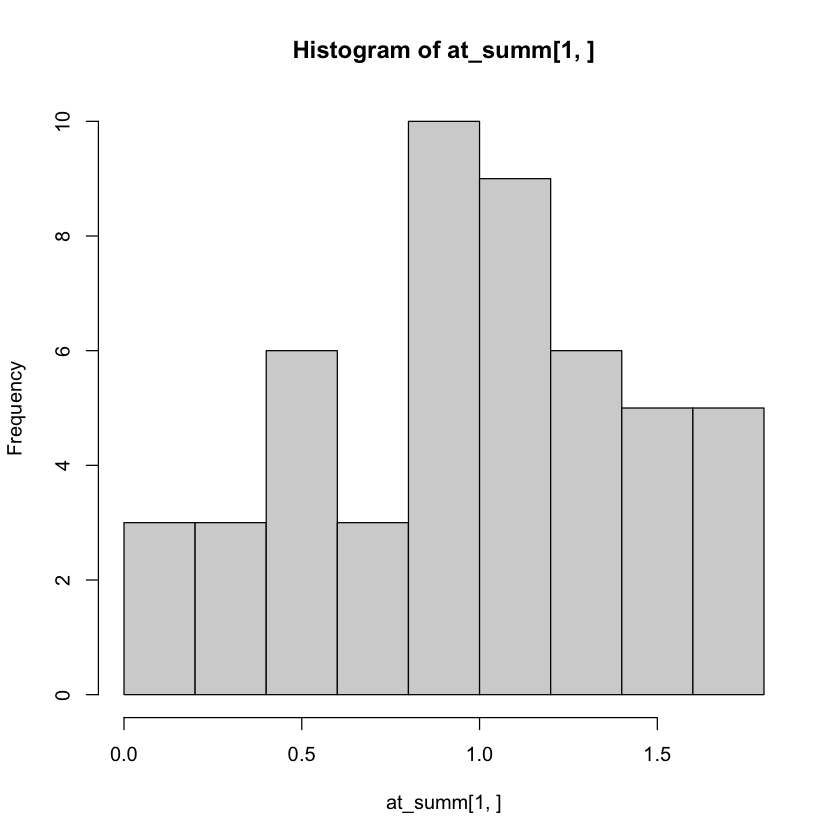

In [274]:
at_summ = sapply(sim_all$data, at_effect)
at_summ

hist(at_summ[1, ])
## mean, bias, etc
summary( at_summ[1, ])
## coverage probability
mean( (at_summ[2,]<1) * (at_summ[3,]>1) )

In [258]:
### 2. IPW estimate 
# there should be a package for IPW analysis 

In [259]:
### 3. Bootstrap estiamte 

In [260]:
### others methods. 

In [261]:
convert_ipynb(input="CausalBTsimulation.ipynb", output = xfun::with_ext("CausalBTsimulation.ipynb", "Rmd"))